In [ ]:
# %cd drive/MyDrive/dl-assigment-2/

# !unzip nature_12K.zip

In [8]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import os

In [9]:
# Resize images to a fixed size
# Convert images to PyTorch tensors
# Normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = torchvision.datasets.ImageFolder(os.path.join('/content/drive/MyDrive/dl-assigment-2/inaturalist_12K','train'),transform=transform)

val_data = torchvision.datasets.ImageFolder(os.path.join('/content/drive/MyDrive/dl-assigment-2/inaturalist_12K','val'),transform=transform)


train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)



Shape of batch of images: torch.Size([64, 3, 224, 224])
Shape of batch of images: torch.Size([3, 224, 224])


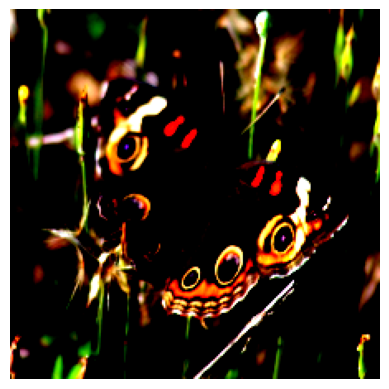

In [14]:
count = 0
for images, labels in train_loader:
    temp_image = images
    temp_labels = labels
    break
print("Shape of batch of images:", temp_image.shape)
print("Shape of batch of images:", temp_image[0].shape)


In [ ]:
class ConvolutionBlocks(nn.Module):
    def __init__(self,in_channels,num_filters,filter_size,activation,num_conv_layers):
        super().__init__()
        self.activationFn=activation
        self.num_conv_layers = num_conv_layers
        self.conv_layers = [nn.Conv2d(in_channels=in_channels,out_channels=num_filters,kernel_size=filter_size,stride=(1, 1),padding=(1, 1),bias=False)] + [nn.Conv2d(in_channels=num_filters,out_channels=num_filters,kernel_size=filter_size,stride=(1, 1),padding=(1, 1),bias=False)]*(num_conv_layers-1)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    def forward(self, x):
        for i in range(self.num_conv_layers):            
            x = self.activationFn(self.conv_layers[i](x))
            x = self.pool(x)
        return x


class Model(nn.Module):
    def __init__(self, in_channels, num_filters, filter_size, activation, neurons_dense, image_shape):
        super().__init__()
        self.activationFn=activation
        self.conv_blocks = ConvolutionBlocks(in_channels, num_filters, filter_size, activation, neurons_dense)
        sz = self.conv_blocks(torch.zeros(*(image_shape))).data.shape 
        # sz[1] * sz[2] * sz[3] = Fully Connected Layer1 input size
        self.fc1 = nn.Linear(sz[1] * sz[2] * sz[3],neurons_dense,bias=True)  
        self.output= nn.Linear(neurons_dense, 10, bias=True)
    
    def forward(self, x):
        x = self.conv_blocks(x) 
        x = self.activationFn(self.fc1(x.reshape(x.shape[0],-1)))
        x = F.softmax(self.output(x),dim=1)
        return x


activation = nn.ReLU()
num_filters = 16
filter_size = 5
in_channels = 3
neurons_dense = 32
# Instantiate Model
model = Model(in_channels,num_filters,filter_size,activation,neurons_dense, (1, 3, 100, 100))
print('Model: ', model)
sample_input = torch.randn(64,3,100,100)
print(model(sample_input).shape)
